

    BA.2 mutations:
        A67V: A nucleotide change from A (Adenine) to T (Thymine) at position 23063 in the Spike (S) gene.
        Y145H: A nucleotide change from T (Thymine) to C (Cytosine) at position 28280 in the Nucleocapsid (N) gene.
        T478K: A nucleotide change from T (Thymine) to A (Adenine) at position 26144 in the Spike (S) gene.

    BA.5 mutations:
        H655Y: A nucleotide change from C (Cytosine) to T (Thymine) at position 22917 in the Spike (S) gene.
        N679K: A nucleotide change from T (Thymine) to G (Guanine) at position 22941 in the Spike (S) gene.


Load mutation profile defintion for Omicron BA.2

In [ ]:
%%bash
wget https://github.com/cbg-ethz/cojac/raw/dev/voc/omicron_ba2_mutations_full.yaml

Load mutation profile defintion for Omicron BA.2

In [ ]:
%%bash
wget https://github.com/cbg-ethz/cojac/raw/dev/voc/omicron_ba5_mutations_full.yaml

In [1]:
import yaml
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Load BA.2 and BA.5 mutations

In [2]:
# load mutations 

with open('omicron_ba2_mutations_full.yaml', 'r') as f:
    ba2_muts = yaml.safe_load(f)
f.close()

with open('omicron_ba5_mutations_full.yaml', 'r') as f:
    ba5_muts = yaml.safe_load(f)
f.close()

In [3]:
all_ba2_pos = set(list(ba2_muts['mut'].keys()) + list(ba2_muts['shared'].keys()))
all_ba5_pos = set(list(ba5_muts['mut'].keys()) + list(ba5_muts['shared'].keys()))

In [4]:
only_ba2 = all_ba2_pos - all_ba5_pos
print("only BA.2:", len(only_ba2))
print(only_ba2)

only_ba5 = all_ba5_pos - all_ba2_pos
print("only BA.5:", len(only_ba5))
print(only_ba5)

only BA.2: 5
{23040, 9866, 26858, 27382, 27259}
only BA.5: 9
{12160, 26529, 21765, 22917, 29734, 23018, 27889, 28882, 28883}


In [5]:
df_muts_def = pd.DataFrame(columns=['position', 'BA.2'])
df_tmp = pd.DataFrame(columns=['position', 'BA.5'])

df_muts_def['position'] = list(ba2_muts['mut'].keys()) + list(ba2_muts['shared'].keys())
df_muts_def['BA.2']=1

df_tmp['position'] = list(ba5_muts['mut'].keys()) + list(ba5_muts['shared'].keys())
df_tmp['BA.5']=1

df_muts_def = pd.merge(df_muts_def, df_tmp, left_on="position", right_on='position', how='outer')
df_muts_def = df_muts_def.fillna(0)

In [6]:
df_muts_def

,position,BA.2,BA.5
0,670,1.0,1.0
1,2790,1.0,1.0
2,4184,1.0,1.0
3,4321,1.0,1.0
4,9424,1.0,1.0
...,...,...,...
69,27889,0.0,1.0
70,12160,0.0,1.0
71,28882,0.0,1.0
72,28883,0.0,1.0


## Positions of mutations that are unique to either BA.2 or BA.5

In [7]:
positions_of_interest = only_ba2.union(only_ba5) 

## Load sample information - location and date

In [8]:
# map sample name to location and date 

fname_sample_names = "../../../../resources/timeline.tsv"

df_mapping = pd.read_csv(fname_sample_names, sep="\t")
df_mapping['my_sample_name'] = df_mapping["sample"] + "/"+df_mapping["batch"]

def f_sample2location(row):
    samplename = row['sample']
    
    location = df_mapping[df_mapping['my_sample_name']==samplename]['location'].values[0]    
    return location

def f_sample2date(row):
    samplename = row['sample']
    date = df_mapping[df_mapping['my_sample_name']==samplename]['date'].values[0]
    
    return date

## Load co-occ mutations

In [9]:
# import co-occ mutations 

df_cocc = pd.read_csv("../../results/all_cooccurring_mutations.csv")
df_cocc = df_cocc[['haplotype_id', 'start', 'end', 'coverage', 'position', 'ref', 'var', 'freq', 'support',
       'sample']]

# map sample name to location and date 
#df_cocc['location'] = df_cocc.apply(f_sample2location, axis=1)
df_cocc['date'] = df_cocc.apply(f_sample2date, axis=1)

In [10]:
df_cocc['date'].unique()

array(['2022-04-07', '2022-04-14', '2022-04-21', '2022-04-28',
       '2022-05-05', '2022-05-12', '2022-04-01', '2022-04-08',
       '2022-04-15', '2022-04-22', '2022-04-29', '2022-05-06',
       '2022-05-13', '2022-04-02', '2022-04-09', '2022-04-23',
       '2022-05-07', '2022-05-14', '2022-05-30', '2022-05-16',
       '2022-04-03', '2022-04-17', '2022-04-24', '2022-05-08',
       '2022-05-15', '2022-04-04', '2022-04-11', '2022-04-18',
       '2022-04-25', '2022-05-09', '2022-04-05', '2022-04-12',
       '2022-04-26', '2022-05-10', '2022-04-06', '2022-04-13',
       '2022-04-20', '2022-05-04', '2022-05-11', '2022-05-18'],
      dtype=object)

In [14]:
# load co-occo mutatins from june on

df_cocc_june = pd.read_csv("../../results/all_cooccurring_mutations_incl_June.csv")
df_cocc_june = df_cocc_june[['haplotype_id', 'start', 'end', 'coverage', 'position', 'ref', 'var', 'freq', 'support',
       'sample']]

# map sample name to location and date 
#df_cocc['location'] = df_cocc.apply(f_sample2location, axis=1)
df_cocc_june['date'] = df_cocc_june.apply(f_sample2date, axis=1)
df_cocc_june = df_cocc_june[df_cocc_june['date'].str.startswith('2022-06')]

In [15]:
df_cocc = pd.concat([df_cocc, df_cocc_june])

In [23]:
df_cocc['date'].unique

<bound method Series.unique of 0        2022-04-07
1        2022-04-07
2        2022-04-07
3        2022-04-07
4        2022-04-07
            ...    
36013    2022-06-29
36014    2022-06-29
36015    2022-06-29
36016    2022-06-29
36017    2022-06-29
Name: date, Length: 16524, dtype: object>

In [24]:
df_cocc["mutation_id"] = df_cocc["ref"] + df_cocc["position"].astype(str) + df_cocc["var"]

## Load coverage

In [61]:
df_coverage = pd.read_csv("../../results/samples.all_coverage.csv")
df_coverage = df_coverage[df_coverage['pos'].isin(list(only_ba5) + list(only_ba2))]
df_coverage['date'] = df_coverage.apply(f_sample2date, axis=1)

In [62]:
df_coverage['date'].unique()

array(['2022-04-07', '2022-04-14', '2022-04-21', '2022-04-28',
       '2022-05-05', '2022-05-12', '2022-06-02', '2022-06-09',
       '2022-06-16', '2022-06-23', '2022-06-30', '2022-04-01',
       '2022-04-08', '2022-04-15', '2022-04-22', '2022-04-29',
       '2022-05-06', '2022-05-13', '2022-06-03', '2022-06-10',
       '2022-06-17', '2022-06-24', '2022-04-02', '2022-04-09',
       '2022-04-16', '2022-04-23', '2022-04-30', '2022-05-07',
       '2022-05-14', '2022-05-30', '2022-04-04', '2022-04-11',
       '2022-04-18', '2022-04-25', '2022-05-02', '2022-05-09',
       '2022-04-05', '2022-04-12', '2022-04-19', '2022-04-26',
       '2022-05-03', '2022-05-10', '2022-04-06', '2022-04-13',
       '2022-04-20', '2022-04-27', '2022-05-04', '2022-05-11',
       '2022-05-18'], dtype=object)

## plot something

In [63]:
df_res = df_cocc[df_cocc['position'].isin(df_muts_def['position'])]
df_res = pd.merge(df_res, df_muts_def, left_on = 'position', right_on = 'position', how='left')

def get_mutation_label(row):
    if (row['BA.5'] == 0) & (row['BA.2'] == 1):
           return row['mutation_id'] + " (BA.2)"
    if (row['BA.2'] == 0) & (row['BA.5'] == 1):
           return row['mutation_id'] + " (BA.5)"

df_res['mutation_label'] = df_res.apply(get_mutation_label, axis=1)

In [64]:
df_res = df_res.drop_duplicates()

In [66]:
# list of mutation labels that should be drop since nothing happens there 

drop_mutation = ['A23040T (BA.2)',
                 'A27259T (BA.2)',
                 'G27382T (BA.2)',
                 'G27382A (BA.2)',
                 'T21765C (BA.5)',
                 'T22917A (BA.5)',
                 'T22917C (BA.5)',
                 'T23018A (BA.5)',
                 'G26529A (BA.5)',
                 'G28883A (BA.5)',
                 'G28883T (BA.5)',
                 'G28883C (BA.5)',
                 'G28882A (BA.5)', 
                 'G12160T (BA.5)'
                ]

In [73]:
df_res['date'].unique()

array(['2022-04-07', '2022-04-14', '2022-04-21', '2022-04-28',
       '2022-05-05', '2022-05-12', '2022-04-01', '2022-04-08',
       '2022-04-15', '2022-04-22', '2022-04-29', '2022-05-06',
       '2022-05-13', '2022-04-02', '2022-04-09', '2022-04-23',
       '2022-05-07', '2022-05-14', '2022-05-30', '2022-05-16',
       '2022-04-03', '2022-04-17', '2022-04-24', '2022-05-08',
       '2022-05-15', '2022-04-04', '2022-04-11', '2022-04-18',
       '2022-04-25', '2022-05-09', '2022-04-05', '2022-04-12',
       '2022-04-26', '2022-05-10', '2022-04-06', '2022-04-13',
       '2022-04-20', '2022-05-04', '2022-05-11', '2022-05-18',
       '2022-06-02', '2022-06-09', '2022-06-03', '2022-06-10',
       '2022-06-17', '2022-06-24', '2022-06-04', '2022-06-11',
       '2022-06-25', '2022-06-05', '2022-06-12', '2022-06-26',
       '2022-06-06', '2022-06-13', '2022-06-20', '2022-06-07',
       '2022-06-14', '2022-06-21', '2022-06-01', '2022-06-08',
       '2022-06-15', '2022-06-29'], dtype=object)

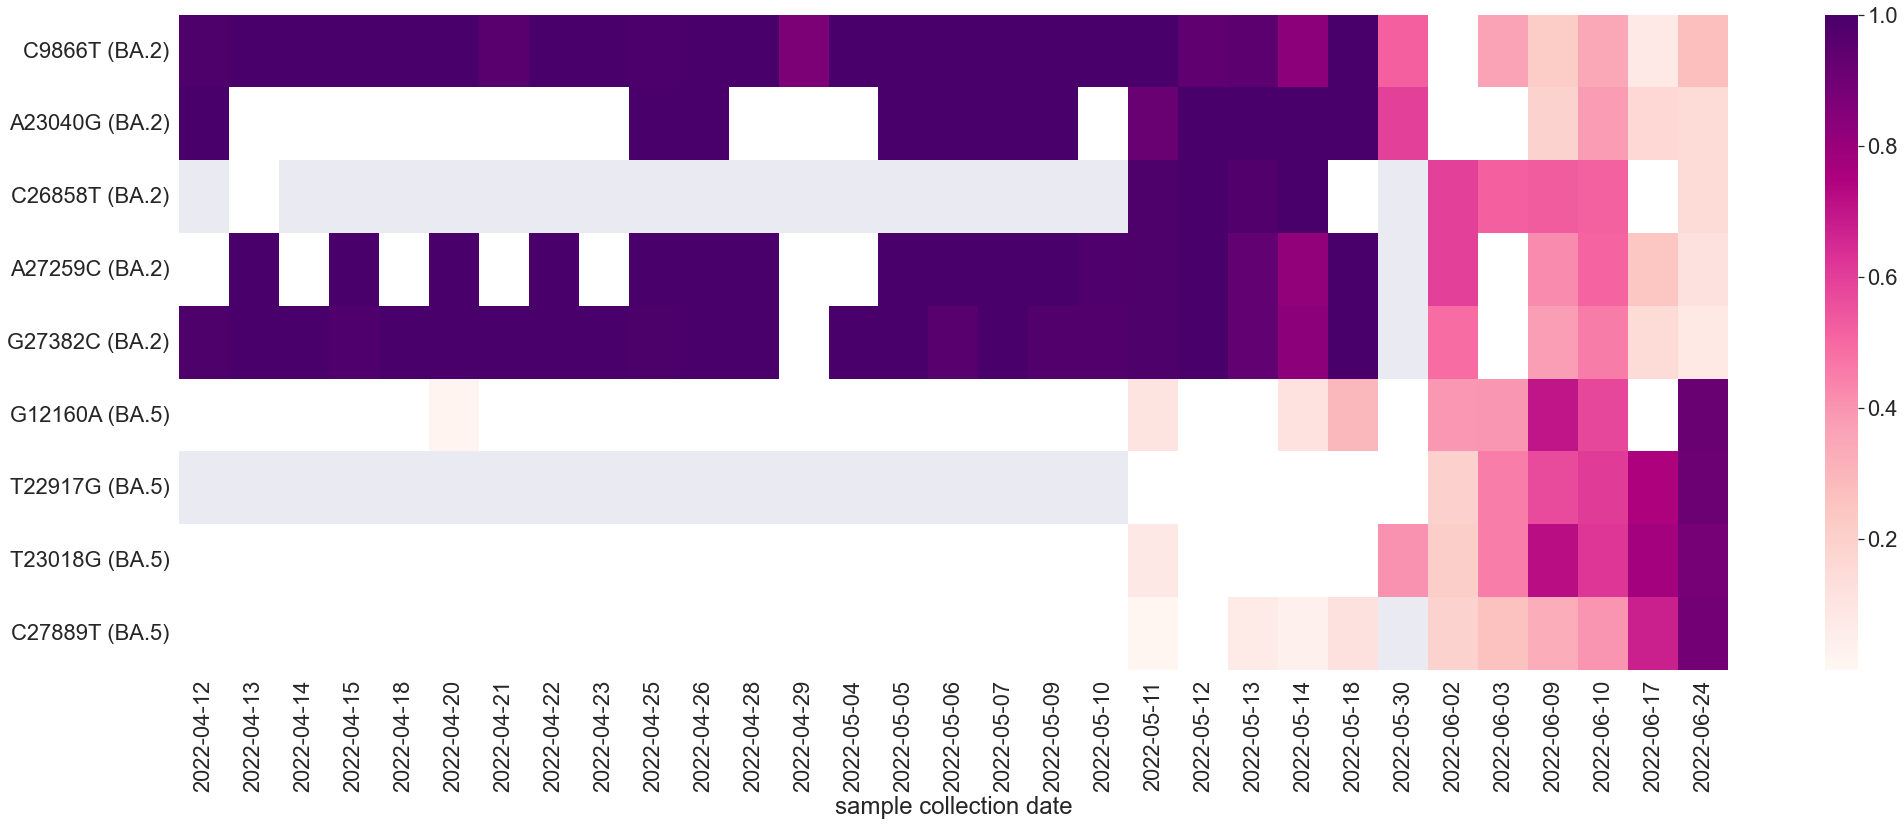

In [86]:
data = df_res[['freq', 'mutation_label', 'date', 'position', "BA.5"]]
data = data[data['position'].isin(list(only_ba5) + list(only_ba2))]
data = data[~data['mutation_label'].isin(drop_mutation)]

drop_early_dates = ['2022-04-01', '2022-04-02', '2022-04-03', '2022-04-04', '2022-04-05', '2022-04-06',
                    '2022-04-07', '2022-04-08', '2022-04-09', '2022-04-10', '2022-04-11']
data = data[~data['date'].isin(drop_early_dates)]


orders = data.sort_values(['BA.5', 'position'])['mutation_label'].unique()

data = data.pivot_table(index=['mutation_label', 'position'], 
                        values='freq',
                        columns='date',
                        fill_value=0,
                       ).reset_index()

data = pd.melt(data, 
               id_vars=['mutation_label', 'position'], 
               var_name='date', 
               value_name='freq')

data = pd.merge(data, df_coverage[['pos', 'date', 'coverage']], 
                left_on = ['date', 'position'], 
                right_on= ['date', 'pos'])

data.loc[data['coverage']<1, 'freq'] = np.nan

import numpy as np
data = data.pivot_table(index='mutation_label', 
                        values='freq', 
                        columns='date',
                        #aggfunc=lambda x: np.log10(x),
                       ).reindex(index=orders)

sns.set(font_scale=2.0)

fig = plt.figure(figsize = (30, 12))

ax = fig.add_subplot(111)

import matplotlib as mpl
cmap = mpl.cm.get_cmap("RdPu").copy()
cmap.set_under(color='white')

sns.heatmap(data,
            cmap=cmap,
            vmin=0.000001,
            ax=ax)

ax.set_ylabel('')
ax.set_xlabel('sample collection date')

fig.tight_layout()

fig.savefig('heatmap_freq_ba2_ba5_specific_mutations.pdf')

In [83]:
data[]

date,2022-04-12,2022-04-13,2022-04-14,2022-04-15,2022-04-18,2022-04-20,2022-04-21,2022-04-22,2022-04-23,2022-04-25,...,2022-05-13,2022-05-14,2022-05-18,2022-05-30,2022-06-02,2022-06-03,2022-06-09,2022-06-10,2022-06-17,2022-06-24
mutation_label,,,,,,,,,,,,,,,,,,,,,
C9866T (BA.2),0.987074,1.0,1.0,1.000000,1.0,1.000000,0.954065,1.0,1.0,0.988570,...,0.947070,0.830986,1.000000,0.520513,0.000000,0.363636,0.220183,0.349206,0.076923,0.270833
A23040G (BA.2),1.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,1.000000,...,1.000000,1.000000,1.000000,0.594547,0.000000,0.000000,0.189093,0.379189,0.160305,0.149180
C26858T (BA.2),NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.974926,0.999806,0.000000,NaN,0.594908,0.523364,0.531211,0.515868,0.000000,0.151893
A27259C (BA.2),0.000000,1.0,0.0,1.000000,0.0,1.000000,0.000000,1.0,0.0,1.000000,...,0.934516,0.815036,1.000000,NaN,0.595579,0.000000,0.419017,0.511353,0.242997,0.119028
G27382C (BA.2),0.988015,1.0,1.0,0.983471,1.0,1.000000,1.000000,1.0,1.0,0.992877,...,0.935167,0.829730,1.000000,NaN,0.491547,0.000000,0.376712,0.456403,0.150560,0.080469
G12160A (BA.5),0.000000,0.0,0.0,0.000000,0.0,0.015668,0.000000,0.0,0.0,0.000000,...,0.000000,0.116227,0.293067,0.000000,0.391822,0.395530,0.700035,0.580472,0.000000,0.915842
T22917G (BA.5),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.195228,0.450000,0.570122,0.605787,0.749621,0.913649
T23018G (BA.5),0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.405453,0.210412,0.450000,0.719742,0.619650,0.775299,0.884607
C27889T (BA.5),0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.066572,0.033913,0.125000,NaN,0.188043,0.258065,0.328853,0.402107,0.672941,0.893048


In [90]:
df_res[df_res['mutation_label']=='C27889T (BA.5)']

,haplotype_id,start,end,coverage,position,ref,var,freq,support,sample,date,mutation_id,BA.2,BA.5,mutation_label
110,haplotype4-27726-27975,27726,27975,4238,27889,C,T,0.066572,1.000000,B2_10_2022_05_13/20220530_HTYKCDRXY,2022-05-13,C27889T,0.0,1.0,C27889T (BA.5)
157,haplotype4-27726-27975,27726,27975,4485,27889,C,T,0.033913,0.982135,C2_10_2022_05_14/20220530_HTYKCDRXY,2022-05-14,C27889T,0.0,1.0,C27889T (BA.5)
365,haplotype4-27726-27975,27726,27975,6990,27889,C,T,0.015021,1.000000,H1_10_2022_05_11/20220530_HTYKCDRXY,2022-05-11,C27889T,0.0,1.0,C27889T (BA.5)
379,haplotype3-27726-27975,27726,27975,42,27889,C,T,0.125000,0.999964,H1_10_2022_05_18/20220603_H7WH5DRX2,2022-05-18,C27889T,0.0,1.0,C27889T (BA.5)
428,haplotype9-27726-28081,27726,28081,920,27889,C,T,0.188043,0.999984,A2_10_2022_06_02/20220617_H7FWCDRX2,2022-06-02,C27889T,0.0,1.0,C27889T (BA.5)
465,haplotype2-27726-28081,27726,28081,2083,27889,C,T,0.328853,1.000000,A2_10_2022_06_09/20220624_H327YDRX2,2022-06-09,C27889T,0.0,1.0,C27889T (BA.5)
523,haplotype4-27726-28081,27726,28081,32,27889,C,T,0.258065,1.000000,B2_10_2022_06_03/20220617_H7FWCDRX2,2022-06-03,C27889T,0.0,1.0,C27889T (BA.5)
598,haplotype9-27726-28081,27726,28081,1139,27889,C,T,0.402107,1.000000,B2_10_2022_06_10/20220624_H327YDRX2,2022-06-10,C27889T,0.0,1.0,C27889T (BA.5)
666,haplotype0-27726-28081,27726,28081,426,27889,C,T,0.672941,1.000000,B2_10_2022_06_17/20220701_H32LGDRX2,2022-06-17,C27889T,0.0,1.0,C27889T (BA.5)
747,haplotype4-27726-28081,27726,28081,189,27889,C,T,0.893048,1.000000,B2_10_2022_06_24/20220708_o28874,2022-06-24,C27889T,0.0,1.0,C27889T (BA.5)


---------

## ---- old stuff ---

------------

In [ ]:
data = df_res[df_res['amplicon'].isin(print_amplicons)][['freq', 'mutation_label', 'date', 'position']]
orders = data.sort_values('position')['mutation_label'].unique()
sns.set(font_scale=1.5)

fig = plt.figure(figsize = (20, 20))

ax = fig.add_subplot(111)
sns.heatmap(data.pivot_table(index='date', values='freq', columns='mutation_label'),
            cmap="RdPu", ax=ax)


In [ ]:
data = df_res[df_res['amplicon'].isin(print_amplicons)][['freq', 'mutation_label', 'date', 'position']]
orders = data.sort_values('position')['mutation_label'].unique()
sns.set(font_scale=1.5)

fig = plt.figure(figsize = (20, 20))

ax = fig.add_subplot(111)
sns.heatmap(data.pivot_table(index='date', values='freq', columns='mutation_label').reindex(columns=orders),
            cmap="RdPu", ax=ax)


In [ ]:
# Define the FacetGrid with the desired row and column variables

data = df_res[df_res['amplicon'].isin(print_amplicons)][['amplicon', 'freq', 'mutation_label', 'date']]

def facet_heatmap(data, color, **kws):
    data = data.pivot_table(index="date", columns='mutation_label', values='freq')
    sns.heatmap(data, cmap='Blues', **kws)

g = sns.FacetGrid(data, col="amplicon", sharey=True)
g.map_dataframe(facet_heatmap)


In [ ]:
df_res

In [ ]:
data = df_res.pivot_table(values='freq', index="mutation_label")

sns.clustermap(data)

## Filter co-occ mutations for amplicons of interest 

In [ ]:
df_cocc[df_cocc['position'].isin(only_ba5)]

In [ ]:
list(amplicons_of_interest['start'])

In [ ]:
df_pivot = df_cocc[df_cocc['position'].isin(only_ba5)].pivot_table(values='freq',
                           index=["date"], 
                           columns='mutation_id', 
                          )

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.set_figwidth(15)
fig.set_figheight(15)


df_pivot = df_cocc[df_cocc['position'].isin(only_ba5)].pivot_table(values='freq',
                           index=["date"], 
                           columns='mutation_id', 
                          )

sns.heatmap(df_pivot, 
            cmap="RdPu",
            ax=ax1,
            linewidths=2,)


df_pivot = df_cocc[df_cocc['position'].isin(only_ba2)].pivot_table(values='freq',
                           index=["date"], 
                           columns='mutation_id', 
                          )

sns.heatmap(df_pivot, 
            cmap="RdPu",
            ax=ax2,
            linewidths=2,)

In [ ]:
df_spec = df_cocc[(df_cocc['start']==28849) & df_cocc['position'].isin(list(all_ba2_pos) + list(all_ba5_pos)) ]


In [ ]:
len(list(all_ba2_pos) + list(all_ba5_pos))

In [ ]:
fig = plt.figure(figsize = (10, 10))

df_pivot = df_spec.pivot_table(values='freq',
                           index=["date"], 
                           columns='mutation_id', 
                          )

sns.heatmap(df_pivot, 
            cmap="RdPu",
            linewidths=2,)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.set_figwidth(15)
fig.set_figheight(15)sl

df_spec = df_cocc[(df_cocc['start']==28849) & df_cocc['position'].isin(list(all_ba2_pos) + list(all_ba5_pos)) ]


df_pivot = df_spec[df_spec['position'].isin(all_ba2_pos)].pivot_table(values='freq',
                           index=["date"], 
                           columns='mutation_id', 
                          )

sns.heatmap(df_pivot, 
            cmap="RdPu",
            ax=ax1,
            linewidths=2,)


df_pivot = df_spec[df_spec['position'].isin(all_ba5_pos)].pivot_table(values='freq',
                           index=["date"], 
                           columns='mutation_id', 
                          )

sns.heatmap(df_pivot, 
            cmap="RdPu",
            ax=ax2,
            linewidths=2,)

In [ ]:
[9805,
 11963,
 21561,
 22774,
 22974,
 26277,
 26621,
 27177,
 27726,
 28536,
 28849,
 28536]


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.set_figwidth(15)
fig.set_figheight(15)

df_spec = df_cocc[(df_cocc['start']==27726) & df_cocc['position'].isin(list(all_ba2_pos) + list(all_ba5_pos)) ]


df_pivot = df_spec[df_spec['position'].isin(all_ba2_pos)].pivot_table(values='freq',
                           index=["date"], 
                           columns='mutation_id', 
                          )

sns.heatmap(df_pivot, 
            cmap="RdPu",
            ax=ax1,
            linewidths=2,)


df_pivot = df_spec[df_spec['position'].isin(all_ba5_pos)].pivot_table(values='freq',
                           index=["date"], 
                           columns='mutation_id', 
                          )

sns.heatmap(df_pivot, 
            cmap="RdPu",
            ax=ax2,
            linewidths=2,)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.set_figwidth(15)
fig.set_figheight(15)


df_spec = df_cocc[(df_cocc['start']==11963) & df_cocc['position'].isin(list(all_ba2_pos) + list(all_ba5_pos)) ]


#df_pivot = df_spec[df_spec['position'].isin(all_ba2_pos)].pivot_table(values='freq',
#                           index=["date"], 
#                           columns='mutation_id', 
#                          )
#
#sns.heatmap(df_pivot, 
#            cmap="RdPu",
#            ax=ax1,
#            linewidths=2,)


df_pivot = df_spec[df_spec['position'].isin(all_ba5_pos)].pivot_table(values='freq',
                           index=["date"], 
                           columns='mutation_id', 
                          )

sns.heatmap(df_pivot, 
            cmap="RdPu",
            ax=ax2,
            linewidths=2,)